In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import ellip, lfilter, butter, find_peaks
from scipy.io import loadmat
import numpy as np
import os
import h5py 

In [13]:
from support import *
import wavegen as wavg
scales =lambda x, min, max: np.where(np.subtract(max, min) != 0, np.divide(np.subtract(x, min), np.subtract(max, min)), np.nan)

In [14]:
# fs = 2000 # Sampling frequency (samples/second)
# duration = 10.0  # Duration of signal (seconds)
# see=10.0

# t, sig = wavg.generate_syth_signal(fs,1, duration,[2,4],5)
# #t, dd_in = wavg.generate_sinusoid(fs, 10, 10, 1, 1, duration)
# #t, dd_in = wavg.generate_sinusoid(fs, 10, 60, 1, 0.5, duration)

# sig_in=scales(sig,sig.min(),sig.max())


# f,ax = plt.subplots(figsize=(20,5))

# ax.set_xlabel('time (s)')
# ax.set_ylabel('amplitude (a.u.)')
# ax.plot(t, sig_in, color='tab:blue',alpha=0.7)

# # ax.set_xlim(0,see)
# # ax.set_xlim(4,8)
# ax.grid(True)
# f.tight_layout()
# plt.show()

### Generate Pulse Train by Delta Modulation 
Function (moved to support): delta_modulation_synced(inputSignal, ON_Threshold, OFF_Threshold)

### Reconstruction of Signal based on Pulse Train
Function (moved to support): LCADC_reconstruct(pulseTrain,Threshold)

### Evaluation of Spike Detection
Function (moved to support): evaluate_SPD(GT_spike_times, detected_spikeTimes, toleranceWindow, samplingInterval)

## Load raw data file

In [15]:
#Options to read: 'EEG-IO', 'EEG-VV', 'EEG-VR', 'EEG-MB'
data_folder = '../EEG-EyeBlinks/EEG-IO' 

# Parameters and bandpass filtering
fs = 250.0
def lowpass(sig, fc, fs, butter_filt_order):
    B,A = butter(butter_filt_order, np.array(fc)/(fs/2), btype='low')
    return lfilter(B, A, sig, axis=0)

# function to read stimulations
def decode_stim(data_path, file_stim):
    interval_corrupt = []
    blinks = []
    n_corrupt = 0
    with open(os.path.join(data_path,file_stim)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if row[0]=="corrupt":
                n_corrupt = int(row[1])
            elif n_corrupt > 0:
                if float(row[1]) == -1:
                    t_end = data_sig[-1,0]
                else:
                    t_end = float(row[1])
                interval_corrupt.append([float(row[0]), t_end])
                n_corrupt = n_corrupt - 1
            elif row[0]=="blinks":
                #check that n_corrupt is 0
                if not n_corrupt==0:
                    print ("!Error in parsing")
            else:
                blinks.append([float(row[0]), int(row[1])])
    blinks = np.array(blinks)

    return interval_corrupt, blinks 

# Reading data files
file_idx = 16
list_of_files = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f)) and '_data' in f]
file_sig = list_of_files[file_idx]
file_stim = list_of_files[file_idx].replace('_data','_labels')
print ("Reading: ", file_sig, file_stim)


# Loading data
if data_folder == '../EEG-EyeBlinks/EEG-IO':
    data_sig = np.loadtxt(open(os.path.join(data_folder,file_sig), "rb"), delimiter=";", skiprows=1, usecols=(0,1,2))
# elif data_folder is '../EEG-EyeBlinks/EEG-VR' or data_folder is '../EEG-EyeBlinks/EEG-VV':
#     data_sig = np.loadtxt(open(os.path.join(data_folder,file_sig), "rb"), delimiter=",", skiprows=5, usecols=(0,1,2))
#     data_sig = data_sig[0:(int(200*fs)+1),:]
#     data_sig = data_sig[:,0:3]
#     data_sig[:,0] = np.array(range(0,len(data_sig)))/fs

# Filtering
data_sig[:,1] = lowpass(data_sig[:,1], 10, fs, 4)
data_sig[:,2] = lowpass(data_sig[:,2], 10, fs, 4)

# MAT = loadmat('./Simulator_Data/C_Easy2_noise005.mat')
# MAT = loadmat('./Simulator_Data/C_Burst_Easy2_noise015.mat')
# rawData = np.array(MAT['data'])[0]
rawData = data_sig[:, 2]
# spikeTimeGT = np.array(MAT['spike_times'])[0][0][0]
# sampling_interval = np.array(MAT['samplingInterval'][0][0]) * 1e-3
# sample_rate = 1/sampling_interval
sample_rate = 250.0
start_time = 34 # seconds
end_time = 37 # seconds
total_time = end_time - start_time

start_sample = int(sample_rate*start_time)
end_sample = int(sample_rate*end_time)
num_samples = end_sample - start_sample
data = rawData[start_sample:end_sample]
# time = np.linspace(start_time, end_time, num_samples)
time = np.linspace(0, total_time, num_samples)

# Center the baseline at 0
data = data - np.mean(data)

# Invert data
data = -data

Reading:  S16_data.csv S16_labels.csv


In [16]:
# time = np.arange(num_samples) / sample_rate
print(f'time shape: {time.shape} and data shape: {data.shape}')

time shape: (750,) and data shape: (750,)


## Apply Filtering

Text(0.5, 0, 'Time (s)')

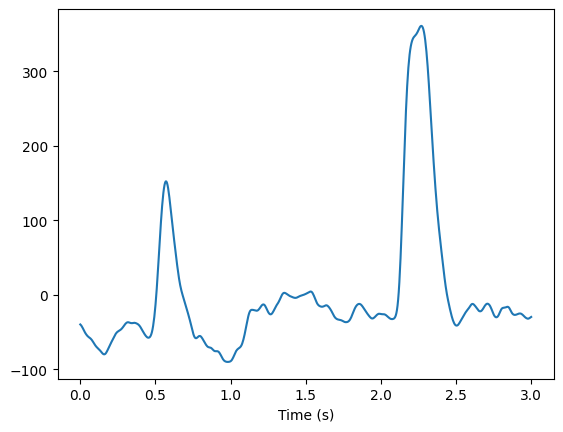

In [17]:
# b, a = butter(4, [300*2/sample_rate, 5000*2/sample_rate], btype='band')
# data = lfilter(b, a, data)
# lim = np.array([0, num_samples]) / sample_rate
plt.plot(time, data)
plt.xlabel('Time (s)')
# plt.xlim(lim)
# plt.ylim([np.min(data), np.max(data)])


In [18]:
# list of name, degree, score
nme = ["time", "value"]

# dictionary of lists
dict = {'time': time, 'value': data}
     
df = pd.DataFrame(dict)
     
# saving the dataframe
df.to_csv('testData.csv')

### Determine Delta Modulation Threshold

In [19]:
def delta_mod_threshold_calc(data):
    # From the work of Quiroga et al "Unsupervised Spike Detection and Sorting with Wavelets and Superparamagnetic Clustering"
    # ABS_THD = 3*np.median(np.abs(data) / 0.6745) # Amplitude Tresholding
    ABS_THD = 30 # Amplitude Tresholding
    data_up = np.copy(data)
    data_up[data_up < ABS_THD] = 0
    peaks, _ = find_peaks(data_up)
    data_down = np.copy(data)
    data_down[data_down > -ABS_THD] = 0
    valleys, _ = find_peaks(abs(data_down))
    median_peak = np.median(data_up[peaks])
    median_valleys = np.median(data_down[valleys])
    spike_amplitude = (median_peak - median_valleys) / 2

    return ABS_THD, data_up, data_down, peaks, valleys, median_peak, median_valleys, spike_amplitude

## Plot ON/OFF events

Amplitude Threshold is: 30
[34 37]
ON events 1 and OFF events 0


Text(0, 0.5, 'Reconstructed')

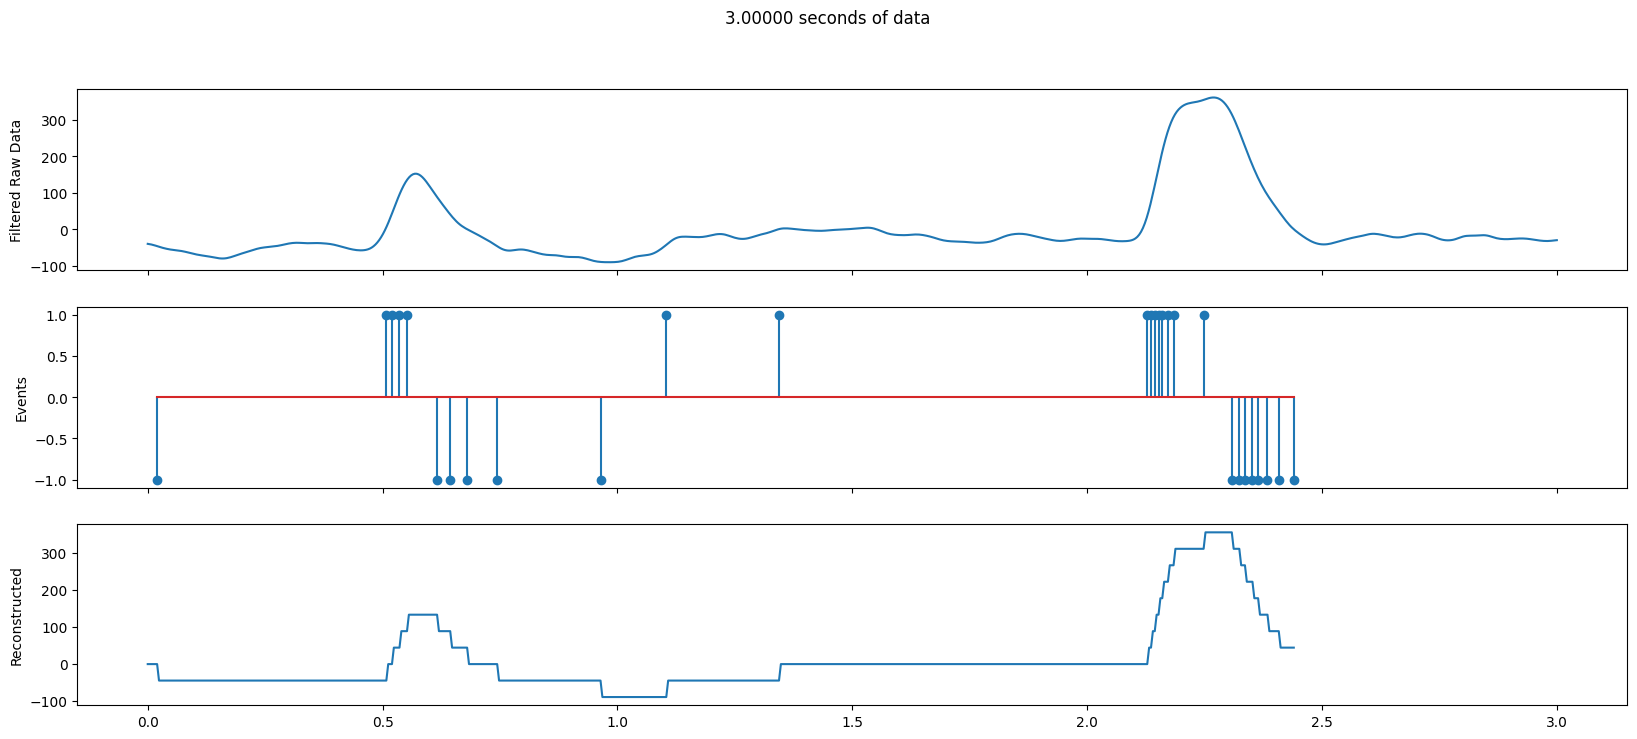

In [20]:
ABS_THD, data_up, data_down, peaks, valleys, median_peak, median_valleys, spike_amplitude = delta_mod_threshold_calc(data)
print(f"Amplitude Threshold is: {ABS_THD}")

multiplier = 0.3
modulation_thd = spike_amplitude * multiplier

lim = np.array([start_time, end_time])
print(lim)

#lim = np.array([1000, 1100])/sample_rate 
# np.array([300, 400])/sample_rate have a spike, 
# np.array([500, 600])/sample_rate have no spike, 
# np.array([1000, 1100])/sample_rate have no spike


ON_Threshold = modulation_thd
OFF_Threshold = -modulation_thd
pulseTrain = delta_modulation_synced(data, ON_Threshold, OFF_Threshold)

# spks = pulseTrain[1][np.logical_and(pulseTrain[0] > 1000, pulseTrain[0] < 1100)]
spks = pulseTrain[1][1]
print(f'ON events {np.sum(spks>0)} and OFF events {np.sum(spks<0)}')

# f,(ax1,ax2,ax3,ax4)= plt.subplots(4,1,figsize=(20,8),sharex=True)
f,(ax1,ax2,ax3)= plt.subplots(3,1,figsize=(20,8),sharex=True)

f.suptitle(f"{total_time:,.5f} seconds of data")

ax1.plot(time,data)
ax1.set_ylabel("Filtered Raw Data")


ax2.stem(np.array(pulseTrain[0])/sample_rate, pulseTrain[1])
ax2.set_ylabel("Events")

sig = LCADC_reconstruct(pulseTrain,modulation_thd)
ax3.plot(np.array(sig[0])/sample_rate, sig[1])
ax3.set_ylabel("Reconstructed")

# ax4.stem((spikeTimeGT+20)/sample_rate, np.ones(spikeTimeGT.shape[0]))
# ax4.set_ylabel("Label")
# ax4.set_xlabel("Time (s)")

# for all in [ax1,ax2,ax3]:
#     all.set_xlim(lim)

ON events 14 and OFF events 14


NameError: name 'spikeTimeGT' is not defined

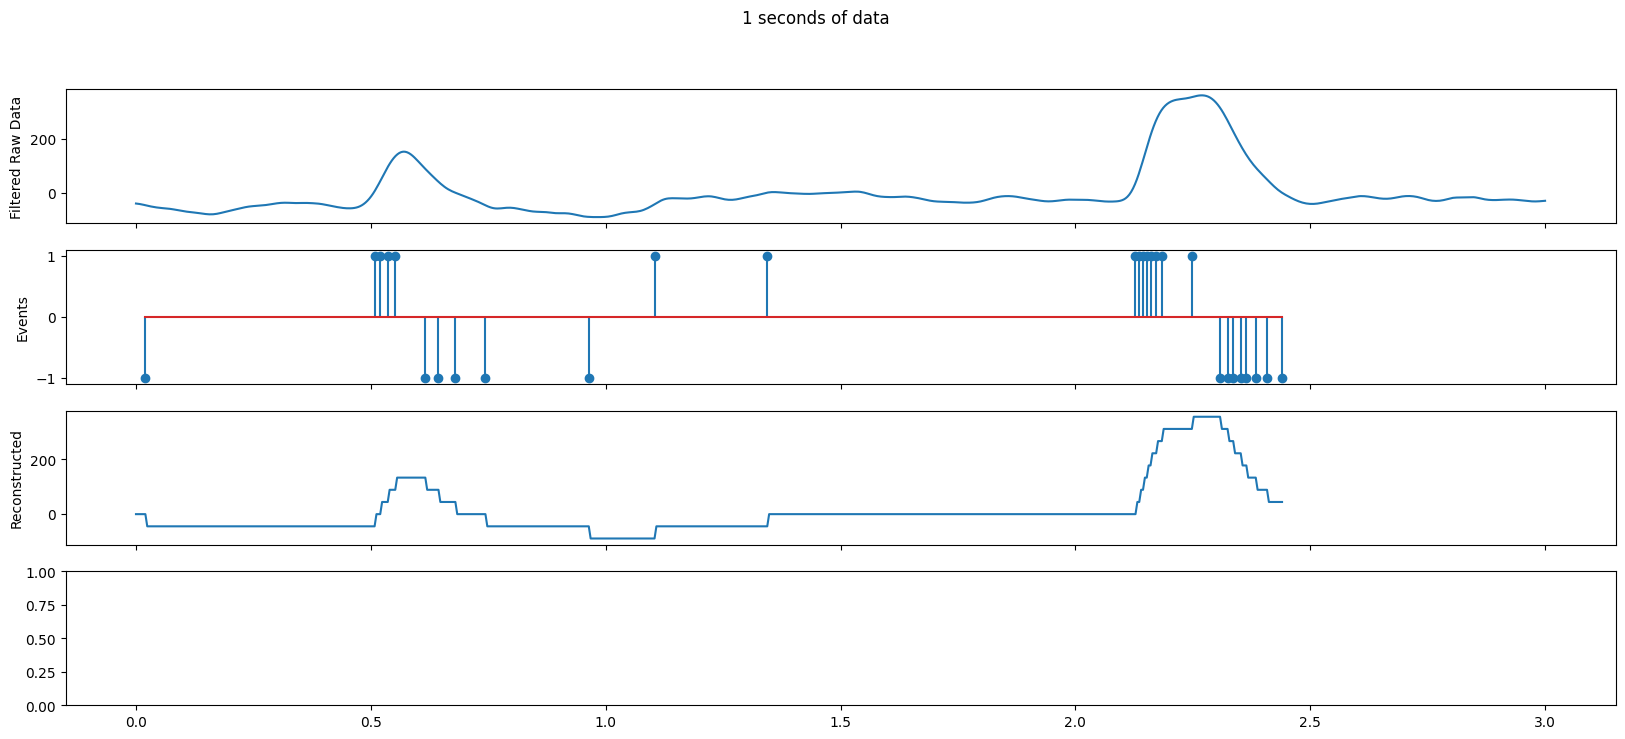

In [21]:
spks=pulseTrain[1]
print(f'ON events {np.sum(spks>0)} and OFF events {np.sum(spks<0)}')

f,(ax1,ax2,ax3,ax4)= plt.subplots(4,1,figsize=(20,8),sharex=True)

f.suptitle(f"1 seconds of data")
ax1.plot(time,data)
ax1.set_ylabel("Filtered Raw Data")

ax2.stem(np.array(pulseTrain[0])/sample_rate, pulseTrain[1])
ax2.set_ylabel("Events")

sig = LCADC_reconstruct(pulseTrain,modulation_thd)
ax3.plot(np.array(sig[0])/sample_rate,sig[1])
ax3.set_ylabel("Reconstructed")

sp_time=(spikeTimeGT+20)/sample_rate
splab_now=sp_time[sp_time<1] # only show spikes that are within the 1 second window
ax4.stem(splab_now, np.ones(splab_now.shape[0]))
ax4.set_ylabel("Label")
ax4.set_xlabel("Time (s)")



### Determine Delta Modulation Threshold (Fixed in time; 2x the standard deviation of the signal)

ON events 35 and OFF events 32


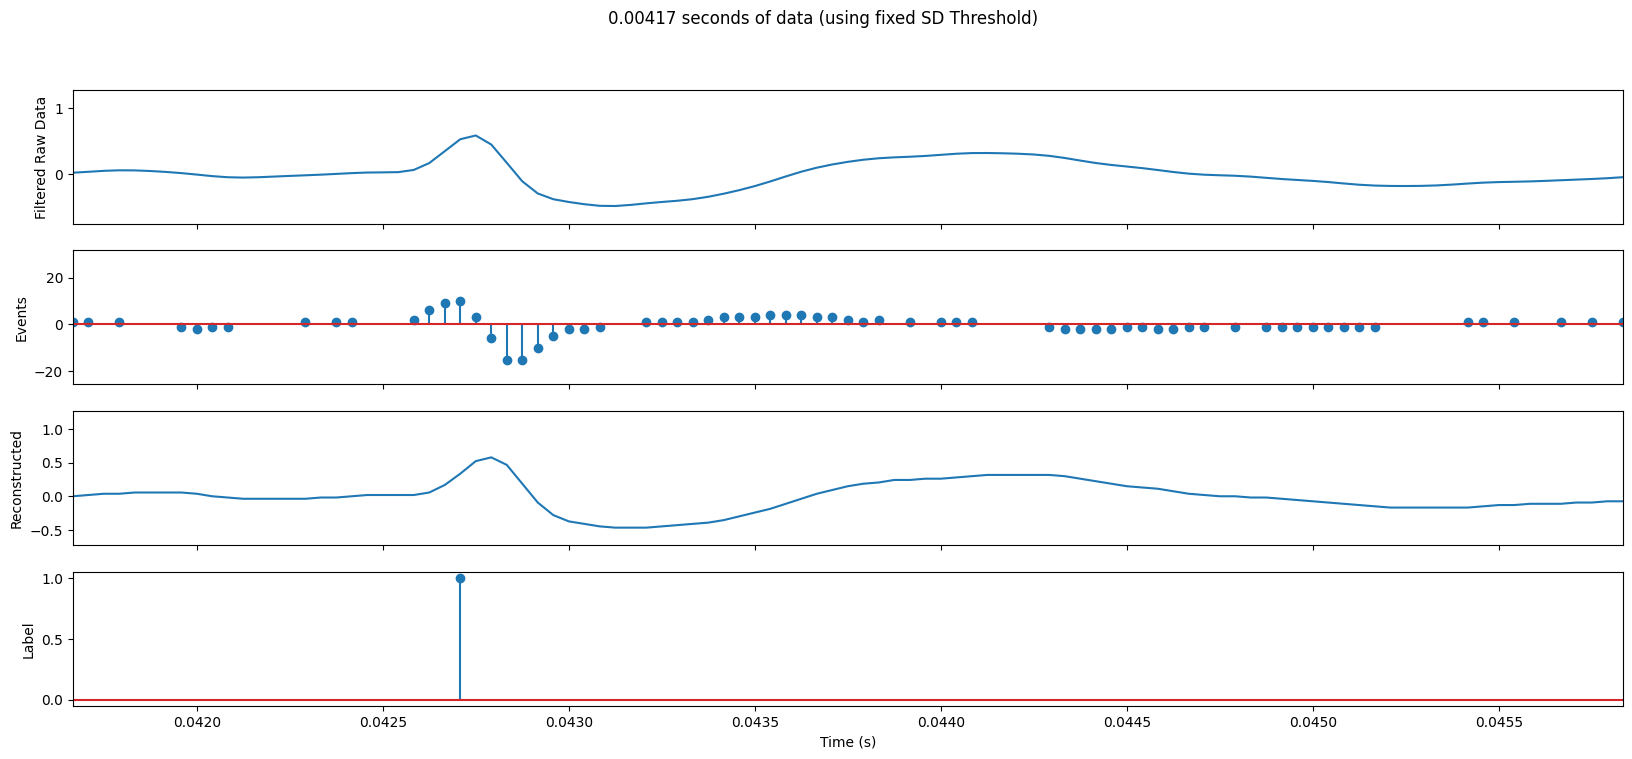

In [ ]:
multiplier = 0.3
init_observation_window=0.01 #in secs 

modulation_thd = np.std(data[0:int(init_observation_window*sample_rate)]) * 2  * multiplier

lim = np.array([1000, 1100])/sample_rate 

#lim = np.array([1000, 1100])/sample_rate 
# np.array([300, 400])/sample_rate have a spike, 
# np.array([500, 600])/sample_rate have no spike, 
# np.array([1000, 1100])/sample_rate have no spike


ON_Threshold = modulation_thd
OFF_Threshold = -modulation_thd
pulseTrain = delta_modulation_synced(data, ON_Threshold, OFF_Threshold)

spks=pulseTrain[1][np.logical_and(pulseTrain[0] > 1000, pulseTrain[0] < 1100)]
print(f'ON events {np.sum(spks>0)} and OFF events {np.sum(spks<0)}')

f,(ax1,ax2,ax3,ax4)= plt.subplots(4,1,figsize=(20,8),sharex=True)

f.suptitle(f"{100/sample_rate:,.5f} seconds of data (using fixed SD Threshold)")

ax1.plot(time,data)
ax1.set_ylabel("Filtered Raw Data")


ax2.stem(np.array(pulseTrain[0])/sample_rate, pulseTrain[1])
ax2.set_ylabel("Events")

sig = LCADC_reconstruct(pulseTrain,modulation_thd)
ax3.plot(np.array(sig[0])/sample_rate,sig[1])
ax3.set_ylabel("Reconstructed")

ax4.stem((spikeTimeGT+20)/sample_rate, np.ones(spikeTimeGT.shape[0]))
ax4.set_ylabel("Label")
ax4.set_xlabel("Time (s)")

for all in [ax1,ax2,ax3,ax4]:
    all.set_xlim(lim)

ON events 4409 and OFF events 4271


Text(0.5, 0, 'Time (s)')

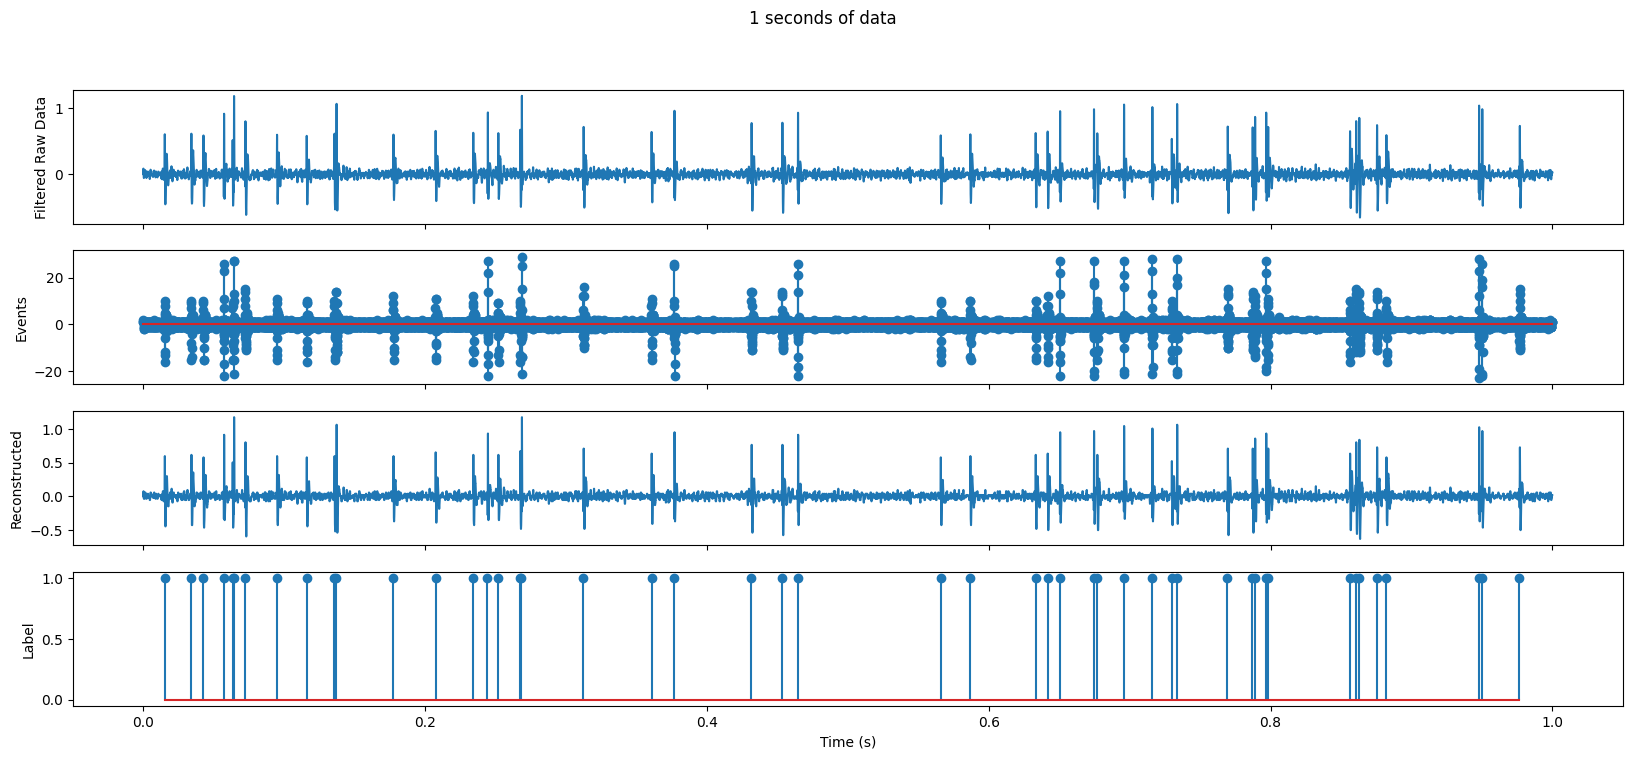

In [ ]:
spks=pulseTrain[1]
print(f'ON events {np.sum(spks>0)} and OFF events {np.sum(spks<0)}')

f,(ax1,ax2,ax3,ax4)= plt.subplots(4,1,figsize=(20,8),sharex=True)

f.suptitle(f"1 seconds of data")
ax1.plot(time,data)
ax1.set_ylabel("Filtered Raw Data")

ax2.stem(np.array(pulseTrain[0])/sample_rate, pulseTrain[1])
ax2.set_ylabel("Events")

sig = LCADC_reconstruct(pulseTrain,modulation_thd)
ax3.plot(np.array(sig[0])/sample_rate,sig[1])
ax3.set_ylabel("Reconstructed")

sp_time=(spikeTimeGT+20)/sample_rate
splab_now=sp_time[sp_time<1] # only show spikes that are within the 1 second window
ax4.stem(splab_now, np.ones(splab_now.shape[0]))
ax4.set_ylabel("Label")
ax4.set_xlabel("Time (s)")

